# A/B Testing

# Problem Statement: Evaluate whether background color has an effect on conversion rate.

# Dataset Info


*   **User ID: Serves as an identifier for each user.**
*   **Group: Contains both the control group (A) and treatment group (B).**
*   **Page Views: Number of pages the user viewed during their session.**
*   **Time Spent: The total amount of time, in seconds, that the user spent on the site during the session.**
*   **Conversion: Indicates whether a user has completed a desired action (Yes/No).**
*   **Device: Type of device used to access the website.**
*   **Location: The country in UK where the user is based in.**



















## Unit of Randomization: user ID
## Primary metric: Conversion (Yes/No)
## Guardrail metrics: Time Spent, Page Views

# Data Loading and Cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from statsmodels.stats.proportion import proportions_ztest


In [2]:
df = pd.read_csv("ab_testing.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB


In [4]:
df.describe()

,User ID,Page Views,Time Spent
count,5000.000000,5000.000000,5000.000000
mean,14925.159000,7.537600,242.512600
std,2869.153773,4.022465,118.254153
min,10001.000000,1.000000,40.000000
25%,12456.250000,4.000000,137.000000
50%,14858.500000,8.000000,243.000000
75%,17379.750000,11.000000,346.000000
max,19995.000000,14.000000,449.000000


In [5]:
df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


### Checking for NULLS in dataset
Finding: No NULLS

In [6]:
df.isnull().sum()

,0
User ID,0
Group,0
Page Views,0
Time Spent,0
Conversion,0
Device,0
Location,0


### Checking Sample Size

Sample Size for each group looks to be almost equal, so that's good.

In [7]:
df['Group'].value_counts(normalize=True)*100

,proportion
Group,
A,50.38
B,49.62


In [8]:
df.replace({'Conversion':{'Yes': 1, 'No': 0}}, inplace=True)
df.replace({'Group':{'A': 'Control', 'B': 'Treatment'}}, inplace=True)

/tmp/ipython-input-810226092.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Conversion':{'Yes': 1, 'No': 0}}, inplace=True)


## Checking if user ID is unique

Finding: It is unique, no duplication of users across groups

In [9]:
usercounts=df.groupby('User ID',as_index=False).size()
usercounts[usercounts['size']>1]

,User ID,size


# **Data Visualization and EDA**

## Distribution of device types across groups is uniform

Text(0.5, 1.0, 'Distribution of device types across groups')

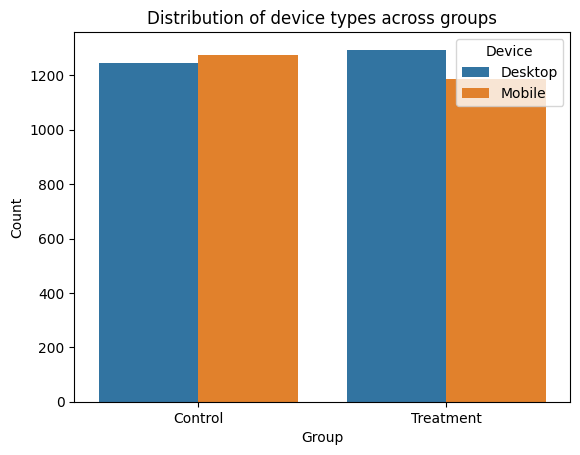

In [10]:
groupwise_devices = df.groupby(['Group','Device']).size()
groupwise_devices=groupwise_devices.reset_index()
groupwise_devices.columns = ['Group','Device','Count']
groupwise_devices
sns.barplot(x='Group',y='Count',hue='Device',data=groupwise_devices)
plt.title('Distribution of device types across groups')

# Distribution of user location also looks uniform across the groups

Text(0.5, 1.0, 'Distribution of user location across groups')

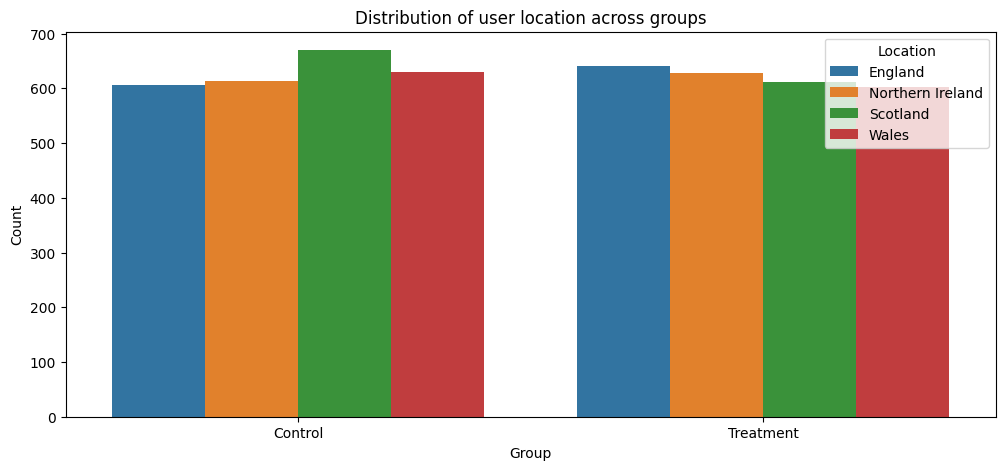

In [11]:
groupwise_location = df.groupby(['Group','Location']).size()
groupwise_location=groupwise_location.reset_index()
groupwise_location.columns = ['Group','Location','Count']
groupwise_location
plt.figure(figsize=(12,5))
sns.barplot(x='Group',y='Count',hue='Location',data=groupwise_location)
plt.title('Distribution of user location across groups')

# Chi-square test independence test to check for randomization in device type distribution across groups
# H0: Device distribution is independent of group
# H1: Device distribution is not independent of group

In [12]:
table = pd.crosstab(df['Group'], df['Device'])
from scipy.stats import chi2_contingency
chi2_contingency(table)

Chi2ContingencyResult(statistic=np.float64(3.731765848529103), pvalue=np.float64(0.05338692515743378), dof=1, expected_freq=array([[1278.6444, 1240.3556],
       [1259.3556, 1221.6444]]))

 The p-value is greater than 0.05, meaning we fail to reject H0. Thus, the device distribution is independent of the group.

# Running Chi-Square test to help in ruling out SRM (Sample Ratio Mismatch) possibility

H0: The split matches the expected 50/50

H1: The split does not match the expected 50/50

In [13]:
from scipy.stats import chisquare
counts = df['Group'].value_counts()
expected_counts = [2500,2500]
pvalue = chisquare(counts, expected_counts).pvalue
print(pvalue)

0.5909905465803058


p-value is greater than 0.05, so we fail to reject H0. This means that the split matches the expected 50/50 and indicates no presence of SRM in this dataset. This means the randomization worked and any differences are purely due to luck/chance.

# Test of significance. Since we don't know which color is actually better, we'll use a two tailed z test.

### H0: Background color has no effect on conversion
### H1: Background color has some effect on conversion

In [14]:
counts = df.groupby('Group')['Conversion'].sum()
nobs = df.groupby('Group')['Conversion'].count()

stat, pval = proportions_ztest(counts, nobs, alternative='two-sided')

print('Z-statistic:', stat)
print('P-value:', pval)


Z-statistic: -10.354488520266216
P-value: 3.9931511894201938e-25


**The p-value is much lesser than 0.05, so we reject H0. This means that a different color has some effect on the conversion rate and other associated metrics.**

# Calculating Conversion rate

In [15]:
df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,Treatment,3,424,0,Mobile,Northern Ireland
1,11682,Control,9,342,0,Mobile,Scotland
2,19825,Control,2,396,0,Desktop,Northern Ireland
3,16080,Treatment,4,318,0,Desktop,Wales
4,18851,Control,1,338,1,Desktop,Scotland


In [16]:
df.head(1)

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,Treatment,3,424,0,Mobile,Northern Ireland


In [17]:
conversion_group_a = df[(df['Group']=='Control') & (df['Conversion']==1)].shape[0]/df[df['Group']=='Control'].shape[0]
conversion_group_b = df[(df['Group']=='Treatment') & (df['Conversion']==1)].shape[0]/df[df['Group']=='Treatment'].shape[0]
print(f'Conversion Rate for Control Group (A): {conversion_group_a*100:.2f}%')
print(f'Conversion Rate for Treatment Group (B): {conversion_group_b*100:.2f}%')

Conversion Rate for Control Group (A): 5.40%
Conversion Rate for Treatment Group (B): 14.07%


# Absolute Lift

In [18]:
abs_lift = conversion_group_b - conversion_group_a
print(f'Absolute lift: {abs_lift:.4f}')
print(f'Absolute lift %: {abs_lift*100:.2f}')

Absolute lift: 0.0867
Absolute lift %: 8.67


# Relative Lift

In [19]:
relative_lift = (conversion_group_b-conversion_group_a)/conversion_group_a
print(f'Relative lift: {relative_lift}')

Relative lift: 1.6054810678805989


# CI interval

In [20]:
summary = df.groupby('Group')['Conversion'].agg(['sum', 'count'])
summary.columns = ['conversions', 'n']
count = [summary.loc['Control','conversions'], summary.loc['Treatment','conversions']]
nobs = [summary.loc['Control','n'], summary.loc['Treatment','n']]
from statsmodels.stats.proportion import confint_proportions_2indep
ci_low, ci_high = confint_proportions_2indep(
    count[0], nobs[0],
    count[1], nobs[1],
    method='wald'
)

print("95% CI for difference:", ci_low, ci_high)


95% CI for difference: -0.1029599287881478 -0.07039888441690295


 Negative CI interval means that the conversion rate for A is lesser than that of Group B. The interval also means **the conversion rate for A is 7 to 10% lower compared to B.**


 Also, if a CI interval includes 0, it means
1.   Uncertain effect
2.   The effect could be +ve or -ve.

But in our case, the interval **excludes 0.** This means there is a stiatistically significant difference between the two colors.



# **Guardrail Metrics**

## Mean time spent across groups
### Assumption: Should be higher for the treatment group

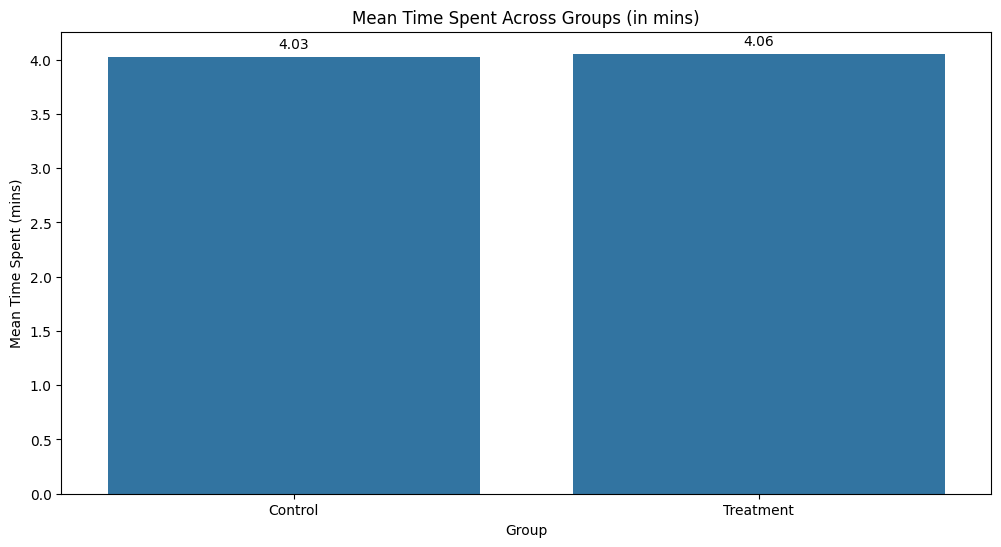

In [21]:
mean_time_a = df[df['Group']=='Control']['Time Spent'].mean()
mean_time_b = df[df['Group']=='Treatment']['Time Spent'].mean()

mean_time_df = pd.DataFrame({
    'Group': ['Control', 'Treatment'],
    'Mean Time Spent': [mean_time_a/60, mean_time_b/60]
})
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Group', y='Mean Time Spent', data=mean_time_df)
plt.title('Mean Time Spent Across Groups (in mins)')
plt.xlabel('Group')
plt.ylabel('Mean Time Spent (mins)')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

# Median time spent by groups

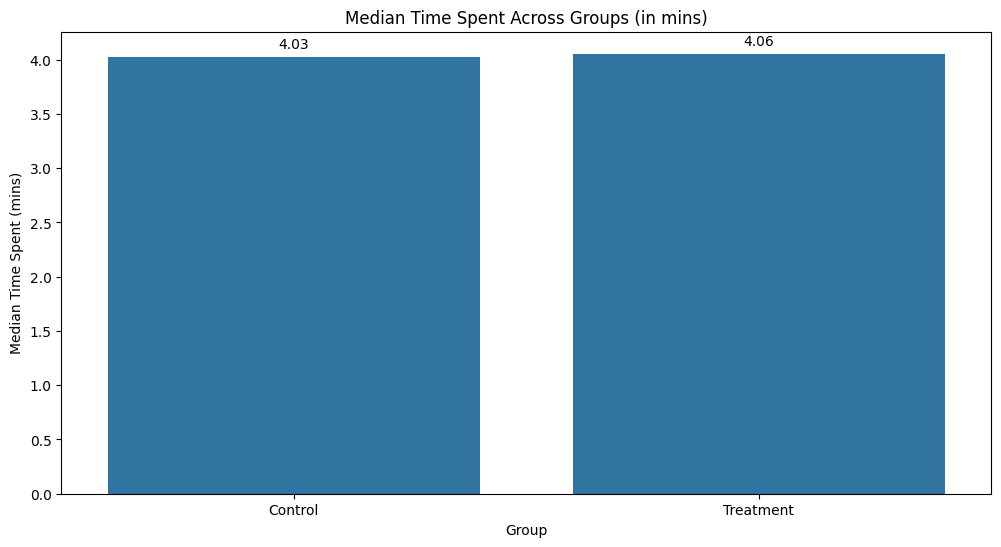

In [22]:
median_time_a = df[df['Group']=='Control']['Time Spent'].median()
median_time_b = df[df['Group']=='Treatment']['Time Spent'].median()

median_time_df = pd.DataFrame({
    'Group': ['Control', 'Treatment'],
    'Mean Time Spent': [mean_time_a/60, mean_time_b/60]
})
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Group', y='Mean Time Spent', data=median_time_df)
plt.title('Median Time Spent Across Groups (in mins)')
plt.xlabel('Group')
plt.ylabel('Median Time Spent (mins)')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

##**Guardrail Metric: Page Views**

Text(0.5, 1.0, 'Average Page Views per Group')

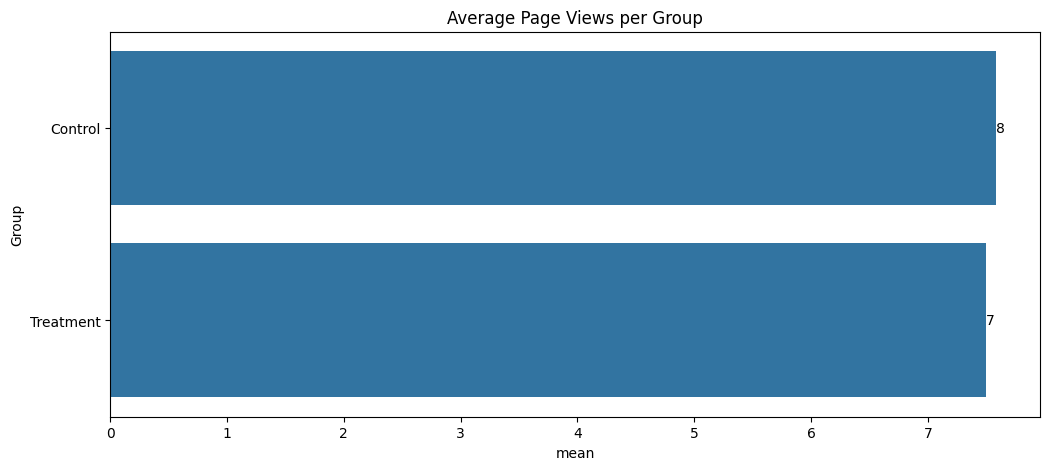

In [23]:
page_views = df.groupby('Group',as_index=False)['Page Views'].agg(['sum','mean'])
plt.figure(figsize=(12,5))
ax = sns.barplot(x='mean',y='Group',data=page_views,orient='h')
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.title('Average Page Views per Group')

# Guardrail Findings

In [24]:
print("*** Guardrail Metric: Time Spent***\n")
print(f"Mean time spent on website by control group: {mean_time_a/60:.2f} mins")
print(f"Mean time spent on website by treatment group: {mean_time_b/60:.2f} mins")
print(f"Median time spent on website by control group: {median_time_a/60:.2f} mins")
print(f"Median time spent on website by treatment group: {median_time_b/60:.2f} mins")
print("\n*** Guardrail Metric: Page Views***\n")
print(f"Total page views by control group: {page_views.loc[0,'sum']}")
print(f"Total page views by treatment group: {page_views.loc[1,'sum']}")
print(f"Average page views by control group: {page_views.loc[0,'mean']:.0f}")
print(f"Average page views by treatment group: {page_views.loc[1,'mean']:.0f}")

*** Guardrail Metric: Time Spent***

Mean time spent on website by control group: 4.03 mins
Mean time spent on website by treatment group: 4.06 mins
Median time spent on website by control group: 4.02 mins
Median time spent on website by treatment group: 4.07 mins

*** Guardrail Metric: Page Views***

Total page views by control group: 19098
Total page views by treatment group: 18590
Average page views by control group: 8
Average page views by treatment group: 7


#**Conclusion**


The initial hypothesis assumed no effect of background color on conversion. However, the confidence interval for the difference in conversion rates excludes zero, indicating a statistically significant effect. Specifically, the treatment variant demonstrated higher conversion rates compared to the control group.



# Limitations:
- Dataset likely simulated
- Short-term engagement only
- No accessibility segmentation
- No long-term retention metric